In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [6]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calcula a distância Haversine entre dois pontos na Terra.
    Retorna a distância em metros.
    """
    R = 6371000  # raio médio da Terra em metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [12]:
def distancia_k(df, limite_ruido=7, max_onibus=5, min_registros=1000, plot_rota=True):
    # --- limpeza e validações iguais às suas ---
    if 'PARKING' in df.columns:
        df = df[df['PARKING'].isna()]

    colunas_necessarias = ['GPSTIMESTAMP', 'LATITUDE', 'LONGITUDE', 'BUSID']
    if not all(col in df.columns for col in colunas_necessarias):
        raise ValueError(f"Faltam colunas obrigatórias: {colunas_necessarias}")

    df = df.copy()
    df['GPSTIMESTAMP'] = pd.to_datetime(df['GPSTIMESTAMP'], errors='coerce')
    df = df.dropna(subset=['GPSTIMESTAMP', 'LATITUDE', 'LONGITUDE', 'BUSID'])
    if df.empty:
        print("⚠️ DataFrame vazio após limpeza. Nada para plotar.")
        return

    line = df['LINE'].iloc[0] if 'LINE' in df.columns and not df['LINE'].isna().all() else 'N/D'
    contagem = df.groupby('BUSID')['GPSTIMESTAMP'].count()
    onibus_validos = contagem[contagem >= min_registros].index
    df = df[df['BUSID'].isin(onibus_validos)]
    if df.empty:
        print(f"⚠️ Nenhum ônibus com pelo menos {min_registros} registros encontrado.")
        return

    unique_ids = df['BUSID'].unique()
    sample_ids = np.random.choice(unique_ids, size=min(max_onibus, unique_ids.size), replace=False)

    # Para o mapa: listas com pontos por categoria
    pontos_vermelhos = []
    pontos_laranja = []
    pontos_amarelo = []

    # --------- GRÁFICO DISTÂNCIA x TEMPO (igual ao seu) ----------
    plt.figure(figsize=(12, 6))
    global_min_t = global_max_t = None

    for busid in sample_ids:
        df_temp = df[df['BUSID'] == busid].copy().sort_values('GPSTIMESTAMP')
        if df_temp.shape[0] < 2:
            continue

        lat = df_temp['LATITUDE'].to_numpy()
        lon = df_temp['LONGITUDE'].to_numpy()

        dist_segmentos = haversine_np(lon[:-1], lat[:-1], lon[1:], lat[1:])
        dist_segmentos = np.where(dist_segmentos < limite_ruido, 0, dist_segmentos)
        dist_acumulada = np.insert(np.cumsum(dist_segmentos), 0, 0.0)

        df_temp = df_temp.iloc[:len(dist_acumulada)].copy()
        df_temp['DISTANCIA_ACUMULADA'] = dist_acumulada

        # ---- DETECÇÃO DE SEQUÊNCIAS DE PARADA ----
        # stopped = True quando não houve aumento de distância entre amostras
        delta = df_temp['DISTANCIA_ACUMULADA'].diff().fillna(0.0)

        # mais robusto que eq(0):
        stopped = pd.Series(np.isclose(delta.to_numpy(), 0.0, atol=1e-6), index=df_temp.index)

        # grupos de runs True/False
        grupos = (stopped != stopped.shift(1)).cumsum()
        tam_run = stopped.groupby(grupos).transform('size')

        mask_vermelho = stopped & (tam_run >= 20)                 # ≥10 pts (~10 min)
        mask_laranja = stopped & (tam_run >= 10) & (tam_run < 20) # 3..9 pts (~5–9,5 min)
        mask_amarelo   = stopped & (tam_run >= 3) & (tam_run < 10)  # 3..9 pts (~1,5–4,5 min)

        # guarda coordenadas para o mapa
        if mask_vermelho.any():
            pontos_vermelhos.append(df_temp.loc[mask_vermelho, ['LONGITUDE', 'LATITUDE']])
        if mask_amarelo.any():
            pontos_amarelo.append(df_temp.loc[mask_amarelo, ['LONGITUDE', 'LATITUDE']])
        if mask_laranja.any():
            pontos_laranja.append(df_temp.loc[mask_laranja, ['LONGITUDE', 'LATITUDE']])

        # curva distância x tempo
        plt.plot(df_temp['GPSTIMESTAMP'], df_temp['DISTANCIA_ACUMULADA'], label=f'Ônibus {busid}')

        tmin, tmax = df_temp['GPSTIMESTAMP'].min(), df_temp['GPSTIMESTAMP'].max()
        global_min_t = tmin if global_min_t is None else min(global_min_t, tmin)
        global_max_t = tmax if global_max_t is None else max(global_max_t, tmax)

    if global_min_t is None:
        print("⚠️ Não há séries com 2+ pontos para plotar.")
        return

    xticks = pd.date_range(start=global_min_t.floor('H'),
                           end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),
                           freq='30min')
    plt.xticks(xticks, [t.strftime('%H:%M') for t in xticks], rotation=45)
    plt.title(f'Distância acumulada em função do tempo - Linha {line}')
    plt.xlabel('Hora'); plt.ylabel('Distância acumulada (m)')
    plt.grid(True, linestyle='--', alpha=0.7); plt.legend(); plt.tight_layout()
    plt.show()

    # --------- MAPA/ROTA COM MARCAÇÃO DE SEQUÊNCIAS ----------
    if plot_rota:
        plt.figure(figsize=(8, 8))

        # Desenha a rota (todas as amostras) de cada ônibus
        for busid in sample_ids:
            df_temp = df[df['BUSID'] == busid].sort_values('GPSTIMESTAMP')
            plt.plot(df_temp['LONGITUDE'], df_temp['LATITUDE'], alpha=0.5, label=f'Ônibus {busid}')

        # Empilha e plota as sequências
        amarelo_df = pd.concat(pontos_amarelo, ignore_index=True) if len(pontos_amarelo) > 0 else None
        vermelhos_df = pd.concat(pontos_vermelhos, ignore_index=True) if len(pontos_vermelhos) > 0 else None
        laranja_df = pd.concat(pontos_laranja, ignore_index=True) if len(pontos_laranja) > 0 else None

        if amarelo_df is not None and not amarelo_df.empty:
            plt.scatter(amarelo_df['LONGITUDE'], amarelo_df['LATITUDE'],
                        s=18, marker='o', label='Parado 1,5–4,5 min (10>x≥3 pts)', color='gold')

        if laranja_df is not None and not laranja_df.empty:
            plt.scatter(laranja_df['LONGITUDE'], laranja_df['LATITUDE'],
                        s=22, marker='o', label='Parado 5-9,5 min (20>x≥10 pts)', color='orange')

        if vermelhos_df is not None and not vermelhos_df.empty:
            plt.scatter(vermelhos_df['LONGITUDE'], vermelhos_df['LATITUDE'],
                        s=22, marker='o', label='Parado ≥10 min (≥20 pts)', color='red')
            
        

        plt.title(f'Rota — Linha {line}\nSequências de parada destacadas')
        plt.xlabel('Longitude'); plt.ylabel('Latitude')
        plt.grid(True, linestyle='--', alpha=0.5); plt.legend(); plt.tight_layout()
        plt.show()


C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


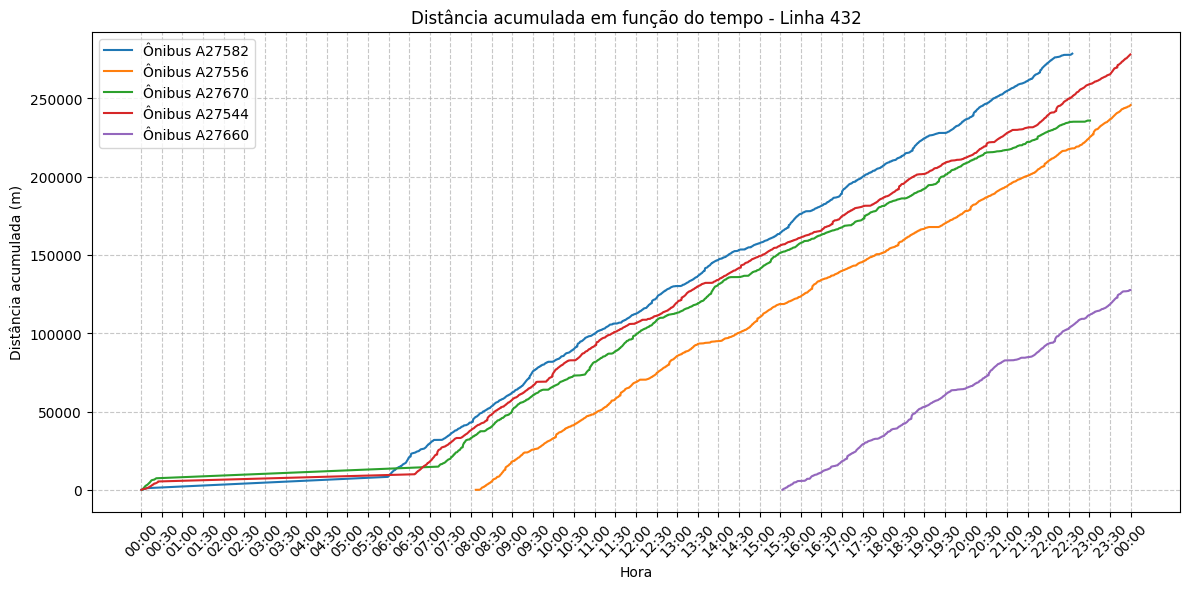

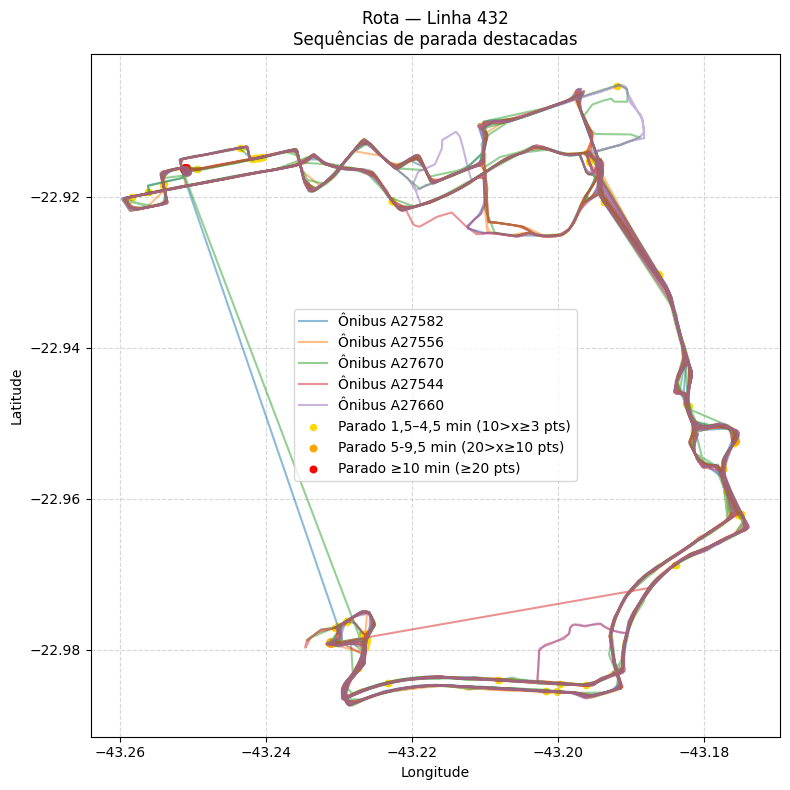

C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


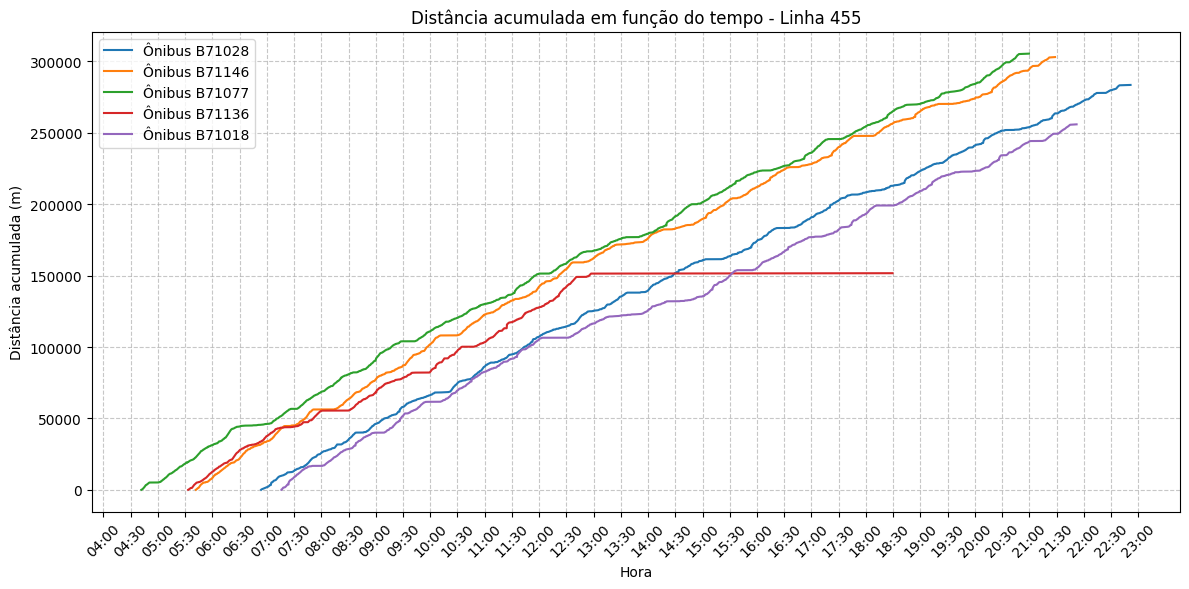

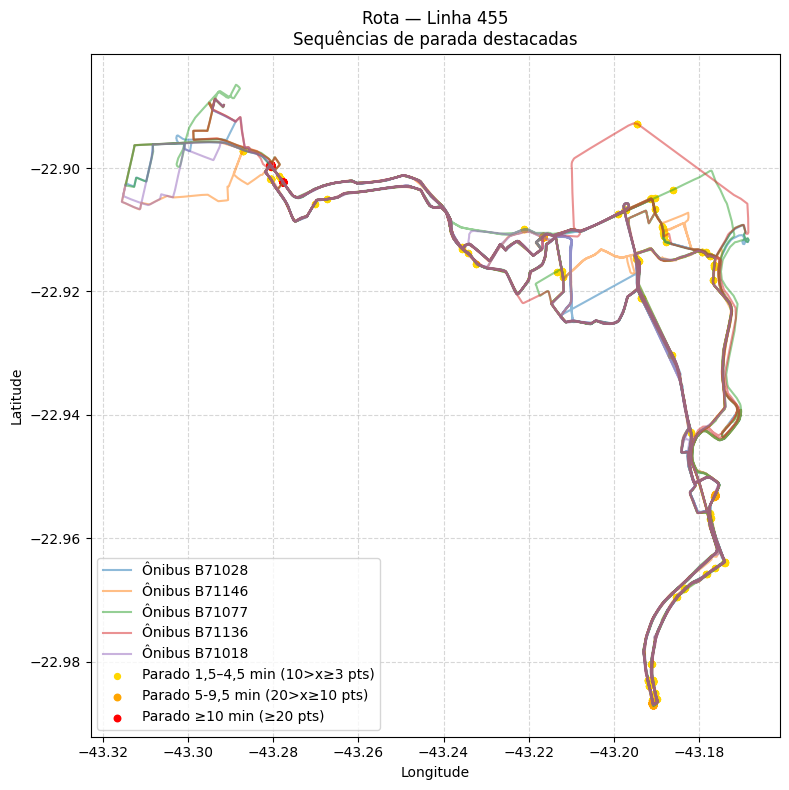

C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


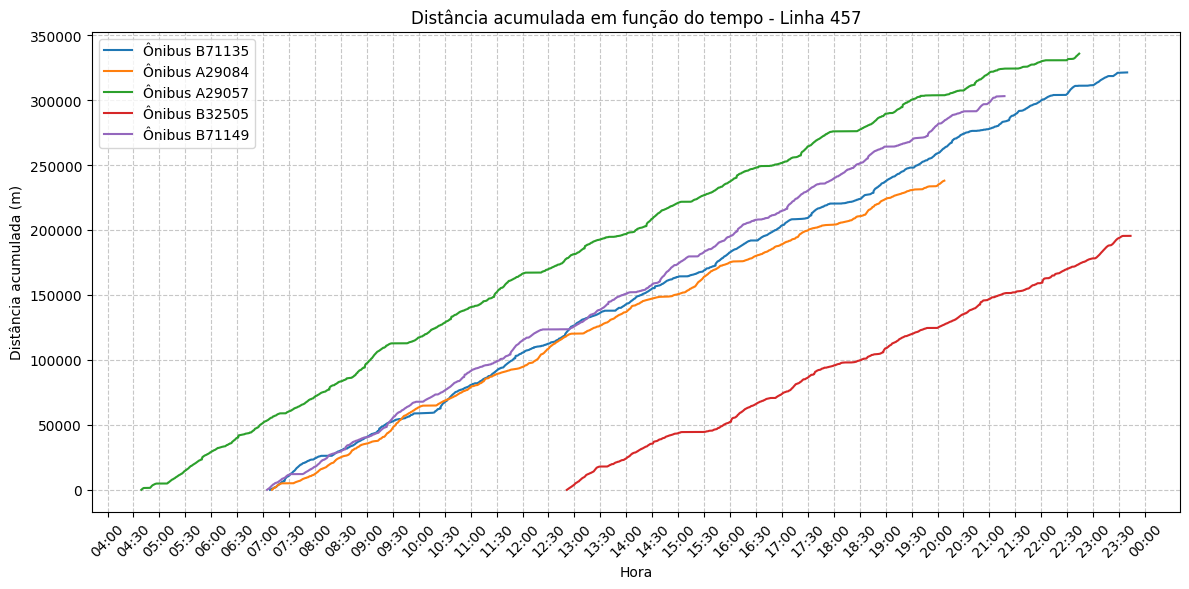

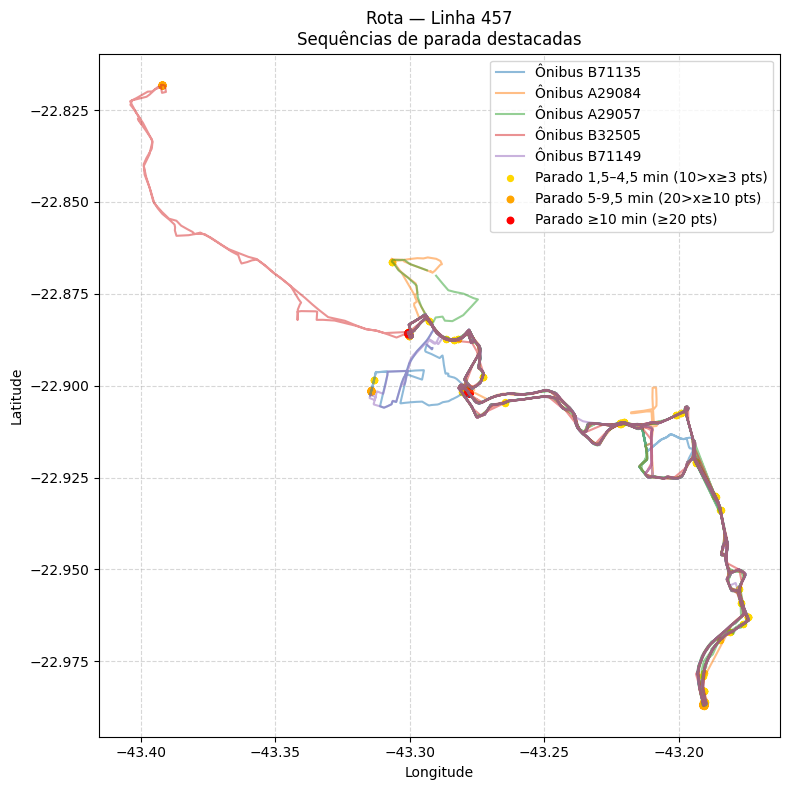

C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_25536\2676880738.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


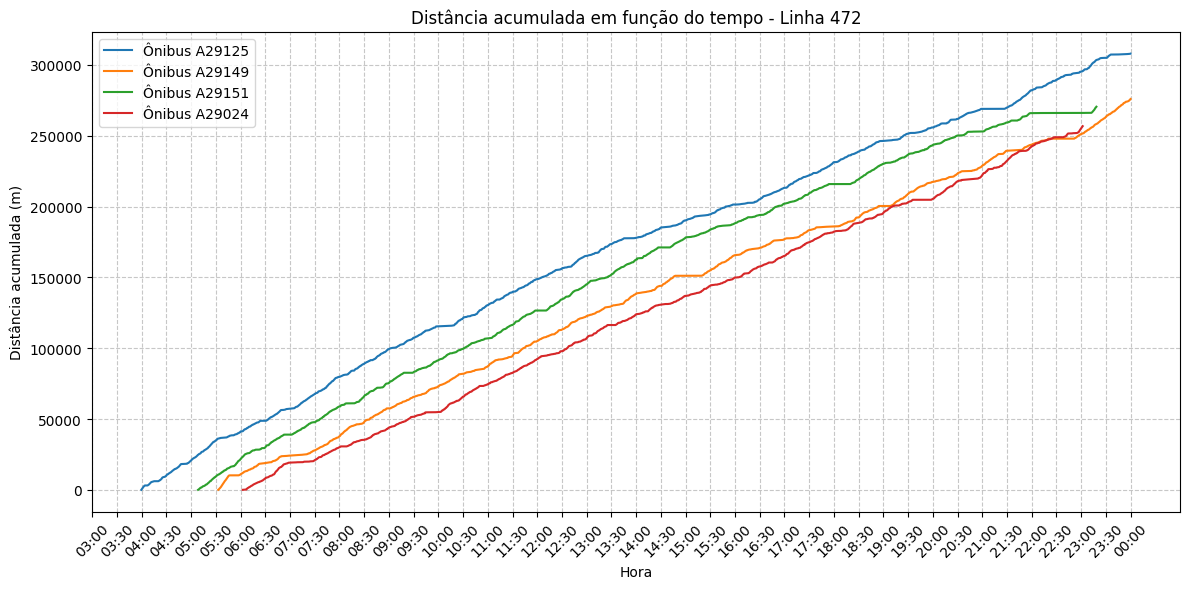

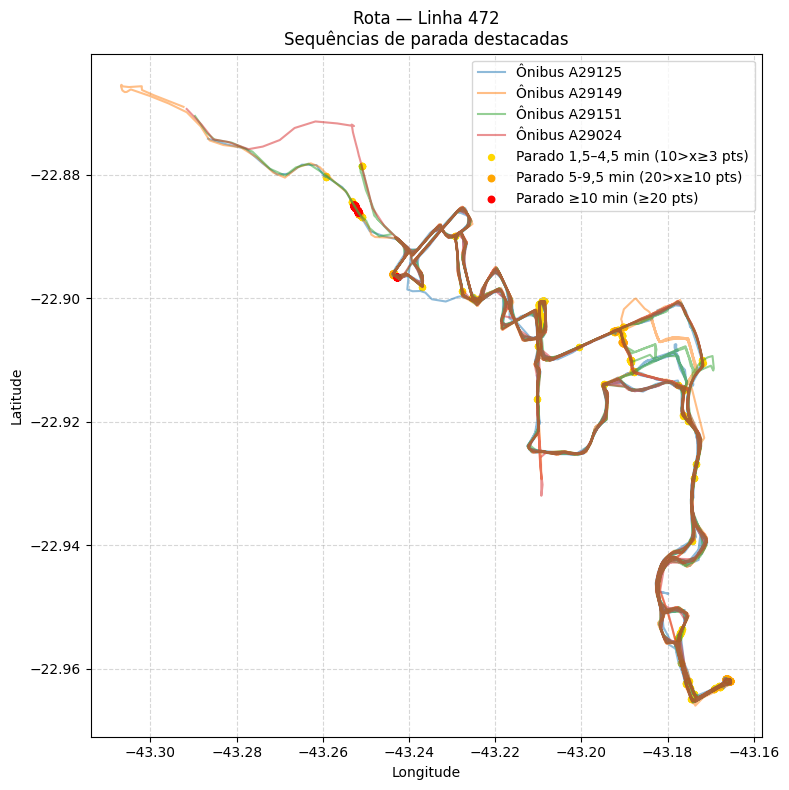

⚠️ Nenhum ônibus com pelo menos 1000 registros encontrado.


In [13]:
if __name__ == "__main__":
    diretorio = "data/bus_csv/sul"
    arquivos_csv = glob.glob(os.path.join(diretorio, "*.csv"))
    dataframes = [pd.read_csv(arquivo) for arquivo in arquivos_csv]

    for df in dataframes:
        distancia_k(df, limite_ruido=7, max_onibus=5, plot_rota=True)
